# Install

In [1]:
# !pip install segmentation-models-pytorch==0.3.3
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install opencv-contrib-python==4.7.0.72
# ! pip install torch==2.0.1
# ! pip install helper==2.5.0
# ! pip install typing_extensions==4.6.3

# Import 

In [1]:
import sys
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper
import rasterio

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [2]:
import albumentations as A
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn
import torch.nn.functional as F

/Users/younes.abid/opt/anaconda3/envs/hackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [4]:
# data = [
#     (0, "nodata", "Areas where the data is masked", [255, 255, 255], "White"),
#     (1, "Water",
#      "Areas where water was predominantly present throughout the year; may not cover areas with sporadic or ephemeral water; contains little to no sparse vegetation, no rock outcrop nor built up features like docks; examples: rivers, ponds, lakes, oceans, flooded salt plains.",
#      [0, 0, 255], "Blue"),
#     (2, "Trees",
#      "Any significant clustering of tall (~15 feet or higher) dense vegetation, typically with a closed or dense canopy; examples: wooded vegetation, clusters of dense tall vegetation within savannas, plantations, swamp or mangroves (dense/tall vegetation with ephemeral water or canopy too thick to detect water underneath).",
#      [0, 255, 0], "Green"), (3, "nodata", "nodata", [0, 0, 0], "Black"),
#     (4, "Flooded vegetation",
#      "Areas of any type of vegetation with obvious intermixing of water throughout a majority of the year; seasonally flooded area that is a mix of grass/shrub/trees/bare ground; examples: flooded mangroves, emergent vegetation, rice paddies and other heavily irrigated and inundated agriculture.",
#      [238, 130, 238], "Violet"),
#     (5, "Crops",
#      "Human planted/plotted cereals, grasses, and crops not at tree height; examples: corn, wheat, soy, fallow plots of structured land.",
#      [255, 165, 0], "Orange"), (6, "nodata", "nodata", [0, 0, 0], "Black"),
#     (7, "Built Area",
#      "Human made structures; major road and rail networks; large homogenous impervious surfaces including parking structures, office buildings and residential housing; examples: houses, dense villages / towns / cities, paved roads, asphalt.",
#      [255, 0, 0], "Red"),
#     (8, "Bare ground",
#      "Areas of rock or soil with very sparse to no vegetation for the entire year; large areas of sand and deserts with no to little vegetation; examples: exposed rock or soil, desert and sand dunes, dry salt flats/pans, dried lake beds, mines.",
#      [128, 128, 128], "Grey"),
#     (9, "Snow/Ice",
#      "Large homogenous areas of permanent snow or ice, typically only in mountain areas or highest latitudes; examples: glaciers, permanent snowpack, snow fields.",
#      [173, 216, 230], "Light Blue"),
#     (10, "Clouds", "No land cover information due to persistent cloud cover.",
#      [105, 105, 105], "Dark Grey"),
#     (11, "Rangeland",
#      "Open areas covered in homogenous grasses with little to no taller vegetation; wild cereals and grasses with no obvious human plotting (i.e., not a plotted field); examples: natural meadows and fields with sparse to no tree cover, open savanna with few to no trees, parks/golf courses/lawns, pastures. Mix of small clusters of plants or single plants dispersed on a landscape that shows exposed soil or rock; scrub-filled clearings within dense forests that are clearly not taller than trees; examples: moderate to sparse cover of bushes, shrubs and tufts of grass, savannas with very sparse grasses, trees or other plants.",
#      [211, 211, 211], "Light Grey")
# ]

# columns = ["Value", "Class Name", "Description", "Color", "Color Name"]
# land_cover_classes_df = pd.DataFrame(data, columns=columns)
# land_cover_classes_df.to_csv('../hackathon-data/classes/land_cover_classes.csv',index=False)

Please try different parameters. And provide explenation for the parameters you choose.

You can find a list of available encoders and weights here https://smp.readthedocs.io/en/latest/encoders.

Try different IMG_SIZE (the image will be up/downsampled)

Available years (2019,2020,2021,2022) 


In [5]:
ROOT_DIR = '../hackathon-data/'
YEAR='2019'
CLASSES_FILE = f'{ROOT_DIR}classes/land_cover_classes.csv'
INFO_FILE = f'{ROOT_DIR}tiles/split/tiles_info.csv'
DATA_DIR = f'{ROOT_DIR}tiles/data/{YEAR}01/'
ANNOTATION_DIR = f'{ROOT_DIR}tiles/annotation/{YEAR}/'

DEVICE= 'cpu'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512 #this is the original size of the tile.
ENCODER = 'timm-efficientnet-b0'#
WEIGHTS = 'imagenet'

# Functions

## Data exploration

In [6]:
def read_image_mask(idx, df, land_cover_classes_df):
    row = df.iloc[idx]

    image_path = DATA_DIR + str(row.tiles_id) + '.tif'
    mask_path = ANNOTATION_DIR + str(row.tiles_id) + '.tif'

    with rasterio.open(image_path) as src:
        image = src.read()
    # Transpose the image dimensions to (height, width, channels)
    image = np.transpose(image, (1, 2, 0))

    with rasterio.open(mask_path) as src:
        mask = src.read()

    # Assuming 'annotation' is a NumPy array with shape (channel, height, width)
    annotation_classes = len(land_cover_classes_df)  # Number of classes

    # Convert the annotation to a tensor
    mask = torch.from_numpy(mask).long().unsqueeze(0)  # Convert to long tensor

    # Perform one-hot encoding
    mask = torch.nn.functional.one_hot(mask, num_classes=annotation_classes)

    mask = mask.squeeze(0)
    mask = mask.squeeze(0)
    mask = np.array(mask)

    return (image, mask)

In [7]:
def display_image_channels(image):
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))

    for i, c in enumerate(['R', 'G', 'B', 'NIR']):
        axs[i].imshow(image[:, :, i], cmap='gray')  # Display each channel
        axs[i].set_title(f'Channel {i+1}: {c}')
    plt.show()

In [8]:
def display_image_mask(image, mask, land_cover_classes_df, cum_cut = False):
    # Assuming 'mask' is a NumPy array containing the annotation mask
    # with shape (h, w, c)

    # Create a dictionary for value-color mapping from the DataFrame
    value_colors = {
        row['Value']: eval(row['Color'])
        for _, row in land_cover_classes_df.iterrows()
    }

    # Create a colored mask by mapping each value to its corresponding color
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for value, color in value_colors.items():
        # Apply the color to all channels of the mask
        colored_mask[mask[..., value] == 1] = color

    if cum_cut:
        # Apply cumulative cut to the image
        for channel in range(3):
            hist, bins = np.histogram(image[..., channel].ravel(), bins=256, range=[0, 255])
            cdf = hist.cumsum()
            cdf_normalized = cdf * hist.max() / cdf.max()
            image[..., channel] = np.interp(image[..., channel], bins[:-1], cdf_normalized)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.set_title('IMAGE')
    # Display the modified image
    ax1.imshow(image)

    ax2.set_title('Annotation')
    ax2.imshow(colored_mask)

    # Create a colorbar legend
    labels = land_cover_classes_df['Class Name'].tolist()
    colors = [np.array(eval(color)) / 255 for color in land_cover_classes_df['Color']]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

## Data augmentation

Feel free to add more augmentation from albumentations

In [9]:
def get_train_augs():
     return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
     ])
def get_valid_augs():
     return A.Compose([
        A.Resize (IMG_SIZE, IMG_SIZE)
     ])

In [10]:
class SegmentationDataset(Dataset):

    def __init__(self, df,land_cover_classes_df, augmentations):
        self.df = df
        self.land_cover_classes_df = land_cover_classes_df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image, mask = read_image_mask(idx, self.df, self.land_cover_classes_df) #(h, w, c)
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']  #(h, w, c)
            mask = data['mask']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  #(c, h, w)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)  #(c, h, w)

        image = torch.Tensor(image) / 255.0
        #mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

## Segmentation model

In [34]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.backbone = smp.Unet(encoder_name=ENCODER,
                                 encoder_weights=WEIGHTS,
                                 in_channels=4,
                                 classes=12,
                                 activation=None)

    def forward(self, images, masks=None):
        logits = self.backbone(images)

        if masks is not None:
            loss = F.cross_entropy(logits, masks)
            return logits, loss

        return logits


In [35]:
def train_fn(dataloader, model, optimizer):
    model.train()  # Turn ON dropout, batchnorm, etc..
    total_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits, loss = model(images, masks)
        loss.backward()  #Cmpute gradients

        optimizer.step()  #update weights and biases

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [31]:
def eval_fn(dataloader, model):
    model.eval()  # Turn OFF dropout, batchnorm, etc..
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss = model(images, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Data exploration

## Land cover classes

In [11]:
land_cover_classes_df = pd.read_csv(CLASSES_FILE)
land_cover_classes_df

,Value,Class Name,Description,Color,Color Name
0,0,nodata,Areas where the data is masked,"[255, 255, 255]",White
1,1,Water,Areas where water was predominantly present th...,"[0, 0, 255]",Blue
2,2,Trees,Any significant clustering of tall (~15 feet o...,"[0, 255, 0]",Green
3,3,nodata,nodata,"[0, 0, 0]",Black
4,4,Flooded vegetation,Areas of any type of vegetation with obvious i...,"[238, 130, 238]",Violet
5,5,Crops,"Human planted/plotted cereals, grasses, and cr...","[255, 165, 0]",Orange
6,6,nodata,nodata,"[0, 0, 0]",Black
7,7,Built Area,Human made structures; major road and rail net...,"[255, 0, 0]",Red
8,8,Bare ground,Areas of rock or soil with very sparse to no v...,"[128, 128, 128]",Grey
9,9,Snow/Ice,Large homogenous areas of permanent snow or ic...,"[173, 216, 230]",Light Blue


## Tiles (train, val, test) 

In [12]:
df = pd.read_csv(INFO_FILE)
df.head()

,Unnamed: 0,tiles_id,empty_tiles,water_tiles,empty_water_tiles,full_tiles,train,val,test
0,0,0,True,False,False,False,False,False,False
1,1,1,True,False,False,False,False,False,False
2,2,10,True,False,False,False,False,False,False
3,3,100,True,False,False,False,False,False,False
4,4,1000,False,False,True,False,False,False,False


In [13]:
train_df = df[df['train']].reset_index()[['tiles_id']]
valid_df = df[df['val']].reset_index()[['tiles_id']]

## Displaying a tile

In [14]:
idx = 2
split = 'train'

In [15]:
image, mask = read_image_mask(idx=idx,
                              df=df[df[split]],
                              land_cover_classes_df=land_cover_classes_df)

In [16]:
print(f"Image shape: {image.shape}") 
print(f"Mask shape: {mask.shape}")

Image shape: (512, 512, 4)
Mask shape: (512, 512, 12)


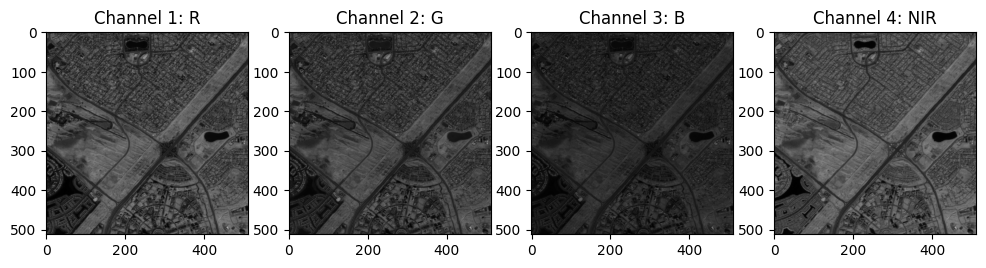

In [17]:
display_image_channels(image)

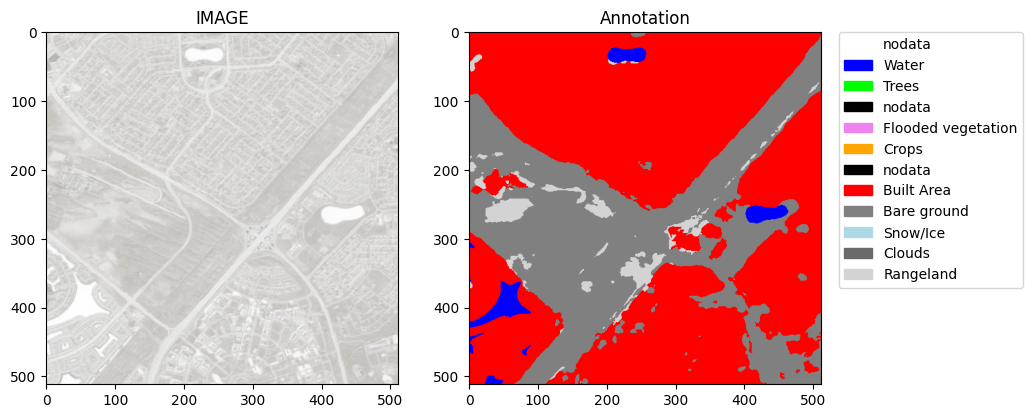

In [18]:
display_image_mask(image, mask, land_cover_classes_df, cum_cut = False)

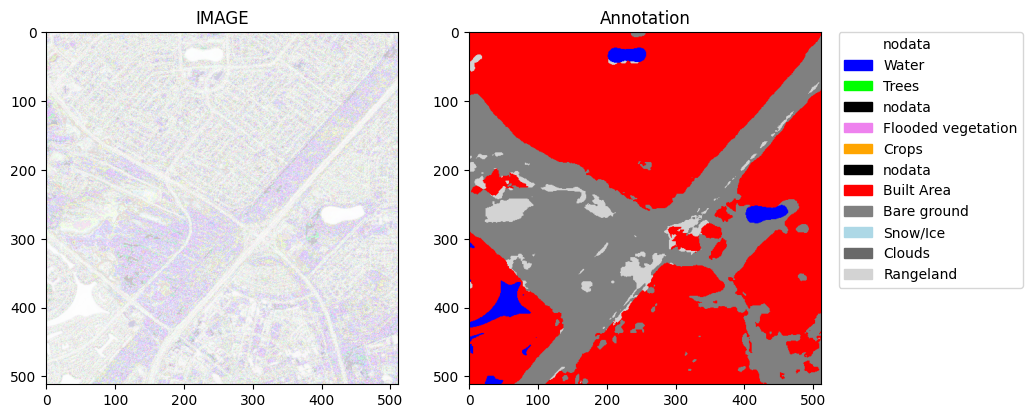

In [19]:
display_image_mask(image, mask, land_cover_classes_df, cum_cut = True)

# Data augmentation

In [20]:
trainset = SegmentationDataset(train_df, land_cover_classes_df,
                               get_train_augs())
validset = SegmentationDataset(valid_df, land_cover_classes_df,
                               get_valid_augs())

In [21]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 1065
Size of validset: 119


# Data loader

In [22]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [23]:
print(f'batch size: {BATCH_SIZE}')
print(f'Total no. of batches in trainloader: {len(trainloader)}')
print(f'Total no. of batches in validloader: {len(validloader)}')

batch size: 8
Total no. of batches in trainloader: 134
Total no. of batches in validloader: 15


In [24]:
for images, masks in trainloader:
    print(f"One batch image shape : {images.shape}")
    print(f"One batch mask shape : {masks.shape}")
    break

One batch image shape : torch.Size([8, 4, 512, 512])
One batch mask shape : torch.Size([8, 12, 512, 512])


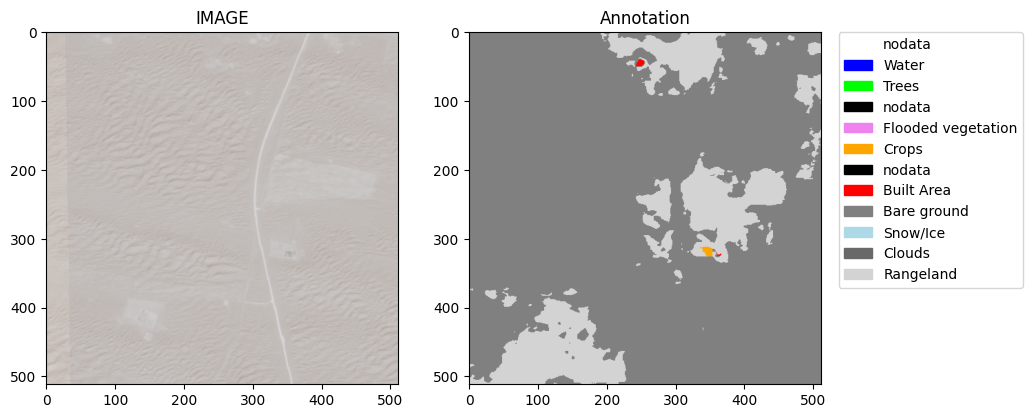

In [25]:
display_image_mask(np.transpose(images[0], (1, 2, 0)),
                   np.transpose(masks[0], (1, 2, 0)), land_cover_classes_df)

# Segmentation Model

## Build

In [36]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

## Train

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_loss:
        torch.save(model.state_dict(), "best-model.pt")
        print("SAVED-MODEL")
        best_loss = valid_loss

    print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss: {valid_loss}")

100%|██████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.61s/it]


SAVED-MODEL
Epoch : 1 Train Loss : 0.8569432307979954 Valid Loss: 0.5169572611649831


100%|██████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.60s/it]


SAVED-MODEL
Epoch : 2 Train Loss : 0.649902279474842 Valid Loss: 0.5006869991620382


 51%|████████████████████████████████▉                                | 68/134 [10:16<09:37,  8.76s/it]

## Test

In [ ]:
# Load the saved model
model = SegmentationModel()
model.load_state_dict(torch.load("best-model.pt"))
model.to(DEVICE)

# Evaluate the model on the test set
test_loss = eval_fn(testloader, model)
print(f"Test Loss: {test_loss}")

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient calculation
with torch.no_grad():
    for images, masks in testloader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        # Forward pass
        logits = model(images)
        predicted_masks = torch.argmax(logits, dim=1)

        # Convert to numpy arrays
        true_labels.extend(masks.cpu().numpy().flatten())
        predicted_labels.extend(predicted_masks.cpu().numpy().flatten())

# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='micro')
print(f"F1 Score: {f1}")

## Inference

In [ ]:
idx = 3

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]
#unsqueeze(0) is used to add an extra dimension for the batch size, 
#as models in PyTorch typically take input in the shape of (batch_size, channel, height, width).
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0